In [1]:
import sys
import torch

sys.path.insert(0, "..")
basedir = "../.."

from common.config import create_object, load_config

%matplotlib widget

torch._dynamo.config.suppress_errors = True
torch._dynamo.disable()
device = torch.device("mps" if torch.backends.mps.is_available() else "cpu")

dconfig = load_config("../autoencoder/configs/data/burgersshift.yaml")
dconfig.datasize.spacedim = 1
dset = create_object(dconfig)

wconfig = load_config("../autoencoder/configs/experiments/weldnormal.yaml")
experiment = create_object(wconfig)

# wconfig = load_config("../autoencoder/configs/experiments/donnormal.yaml")
# experiment = create_object(wconfig)

# wpcaconfig = load_config("../autoencoder/configs/experiments/weldpca.yaml")
# wpcaconfig.windows = 3
# wpcaconfig.aeparams.reduced = 10
# pcaexperiment = create_object(wpcaconfig)

Using backend: pytorch
Other supported backends: tensorflow.compat.v1, tensorflow, jax, paddle.
paddle supports more examples now and is recommended.


In [6]:
import sys
import copy
import torch
import models

import torch.nn as nn

# Ensure your project root is on PYTHONPATH so that common.config can be found
sys.path.insert(0, "..")
basedir = "../.."

from common.config import create_object, load_config

def train_weld_from_yaml(datastr, expstr, k, train=True, **args):
    W = args.get("W", 1)
    krrtrans = args.get("krrtrans", False)
    epochs = args.get("epochs", 300)
    lamb = args.get("lamb", 0)
    finetune = args.get("finetune", True)
    accumulateprop = args.get("accumulateprop", False)
    autonomous = args.get("autonomous", True)

    data_yaml = f"../autoencoder/configs/data/{datastr}"
    exp_yaml  = f"../autoencoder/configs/experiments/{expstr}"

    dconfig = load_config(data_yaml)
    if hasattr(dconfig, "datasize") and hasattr(dconfig.datasize, "spacedim"):
        dconfig.datasize.spacedim = 1
    dset = create_object(dconfig)

    wconfig = load_config(exp_yaml)
    experiment = create_object(wconfig)

    print(dset.data.shape)

    if isinstance(experiment, models.WeldHelper):
        weld1 = experiment.create_weld(dset, windows=W, k=k, td=None, seed=0, device=device, accumulateprop=accumulateprop, autonomous=autonomous)

        if not train:
            return weld1

        if wconfig["aeclass"] == "GIAutoencoder":
            weld1.train_aes(epochs, lr=1e-3, save=False, gridbatch=32)
            weld1.train_propagators(epochs, lr=1e-4, save=False)
        else:
            if lamb > 0:
                weld1.train_aes_plus_props(epochs, lr=1e-3, save=False, lamb=lamb)

                if finetune:
                    weld1.train_propagators(epochs, lr=1e-4, save=False)

            elif lamb == -1:
                weld1.train_aes_alternate_props(epochs, lr=1e-3, save=False)

                if finetune:
                    weld1.train_propagators(epochs, lr=1e-4, save=False)

            else:
                weld1.train_aes(epochs, lr=1e-3, save=False)
                weld1.train_propagators(epochs, lr=1e-4 if not accumulateprop else 1e-3, save=False)

        if W > 1:
            if krrtrans:
                weld1.train_transcoders_krr(save=False, ridge=1e-4, kernel="rbf")
            else:
                weld1.train_transcoders(epochs, lr=1e-4, save=False)

    else:
        weld1 = experiment.create_timeinput(dset, td=None, seed=0, device=device)
        if not train:
            return weld1

        weld1.train_model(int(epochs * 1.5), save=True, lr=1e-3)

    return weld1

dargs = {"W": 1, "epochs": 300}

dsets = ["burgersscale", "burgersshift", "hatsscale", "hatsshift", "kdvscale", "kdvshift"]

for dname in dsets:
    weldff0 = train_weld_from_yaml(f"{dname}.yaml", "weldnormal.yaml", 4, lamb=1, W=3, epochs=300, finetune=True)
    weldff0.save_models()
    #don0 = train_weld_from_yaml(f"{dname}.yaml", "donnormal.yaml", 4, lamb=0, W=1, epochs=300)


#weldffTC = train_weld_from_yaml("droplettrigpoly2.yaml", "weldtc.yaml", 6, lamb=1, W=1, epochs=300)

#weldffminus1 = train_weld_from_yaml("dropletbells.yaml", "weldnormal.yaml", 6, lamb=-1, W=1, epochs=400, finetune=True)

#weldff0accum.train_propagators(epochs, lr=1e-4, save=False, accumulateprop=True)

(500, 201, 512)
Training 3 WeldNet AEs and props together
Number of NN trainable parameters 1519516
Starting training WeldNet AE + Prop 1/3 (0->66) at Thu Jun 19 14:53:23 2025...
train torch.Size([400, 67, 512]) test (100, 67, 512)
1: Train Loss 9.642e-02 + 1.182e-04, LR 1.000e-03, Relative AE Error (1, 2, inf): 0.579173, 0.581724, 0.841104
11: Train Loss 6.264e-03 + 1.673e-07, LR 1.000e-03, Relative AE Error (1, 2, inf): 0.140940, 0.166112, 0.433891
21: Train Loss 8.539e-04 + 1.421e-06, LR 1.000e-03, Relative AE Error (1, 2, inf): 0.041781, 0.055631, 0.285195
31: Train Loss 5.621e-04 + 5.804e-07, LR 1.000e-03, Relative AE Error (1, 2, inf): 0.025182, 0.032987, 0.203554
41: Train Loss 1.515e-04 + 3.557e-07, LR 1.000e-03, Relative AE Error (1, 2, inf): 0.018948, 0.024887, 0.157404
51: Train Loss 1.073e-04 + 4.303e-07, LR 1.000e-03, Relative AE Error (1, 2, inf): 0.015720, 0.020628, 0.142318
61: Train Loss 6.815e-05 + 3.277e-07, LR 1.000e-03, Relative AE Error (1, 2, inf): 0.012707, 0.01

/Users/bdahal6/Desktop/aenet/.venv/lib/python3.10/site-packages/torch/utils/_device.py:104: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.detach().clone() or sourceTensor.detach().clone().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return func(*args, **kwargs)


1: Train Loss 3.342e-07, LR 1.000e-04, Relative Propagator Error (1, 2, inf): 0.181578, 0.163919, 0.146747
11: Train Loss 1.471e-07, LR 1.000e-04, Relative Propagator Error (1, 2, inf): 0.012788, 0.012817, 0.013638
21: Train Loss 1.376e-07, LR 1.000e-04, Relative Propagator Error (1, 2, inf): 0.011532, 0.011279, 0.011264
31: Train Loss 1.428e-07, LR 1.000e-04, Relative Propagator Error (1, 2, inf): 0.023616, 0.022875, 0.022863
41: Train Loss 1.440e-07, LR 1.000e-04, Relative Propagator Error (1, 2, inf): 0.037746, 0.035425, 0.033781
51: Train Loss 1.510e-07, LR 1.000e-04, Relative Propagator Error (1, 2, inf): 0.053888, 0.050057, 0.046720
61: Train Loss 1.245e-07, LR 1.000e-05, Relative Propagator Error (1, 2, inf): 0.007529, 0.007342, 0.007438
71: Train Loss 1.243e-07, LR 1.000e-05, Relative Propagator Error (1, 2, inf): 0.007784, 0.007520, 0.007548
81: Train Loss 1.243e-07, LR 1.000e-05, Relative Propagator Error (1, 2, inf): 0.008138, 0.007799, 0.007766
91: Train Loss 1.241e-07, LR 

NameError: name 'prop' is not defined

In [32]:
ff0 = train_weld_from_yaml(f"{dname}.yaml", "ffnetnormal.yaml", 4, lamb=0, W=1, epochs=300, train=False)

(500, 201, 512)


In [ ]:
weldtest = train_weld_from_yaml(f"{dname}.yaml", "weldnormal.yaml", 6, lamb=0, W=2, epochs=300, train=False)

In [ ]:
weldtest.transcoders = []
weldtest.train_transcoders(300, lr=1e-4, propagated_trans=True)

Training 2 WeldNet Transcoders


/Users/bdahal6/Desktop/aenet/.venv/lib/python3.10/site-packages/torch/utils/_device.py:104: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.detach().clone() or sourceTensor.detach().clone().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return func(*args, **kwargs)


Number of NN trainable parameters 184506
Starting training Weldnet transcoder 1/1 (100) at Tue Jun 17 16:30:10 2025...
train torch.Size([400, 6, 2]) test (100, 6, 2)
1: Train Loss 1.767e+00, LR 1.000e-04, Relative Transcoding Error (1, 2, inf): 0.993309, 1.098238, 1.281440
11: Train Loss 1.089e-01, LR 1.000e-04, Relative Transcoding Error (1, 2, inf): 0.237966, 0.230351, 0.235511
21: Train Loss 6.438e-03, LR 1.000e-04, Relative Transcoding Error (1, 2, inf): 0.063416, 0.062690, 0.064857
31: Train Loss 1.018e-03, LR 1.000e-04, Relative Transcoding Error (1, 2, inf): 0.027535, 0.028625, 0.030596
41: Train Loss 3.431e-04, LR 1.000e-04, Relative Transcoding Error (1, 2, inf): 0.018328, 0.018837, 0.020065
51: Train Loss 2.109e-04, LR 1.000e-04, Relative Transcoding Error (1, 2, inf): 0.014503, 0.014822, 0.015617
61: Train Loss 1.552e-04, LR 1.000e-04, Relative Transcoding Error (1, 2, inf): 0.012159, 0.012543, 0.013271
71: Train Loss 1.188e-04, LR 1.000e-04, Relative Transcoding Error (1, 2

{'losses': [1.8852895498275757,
  1.6863281726837158,
  1.7873549461364746,
  2.116515636444092,
  1.821092963218689,
  1.8450913429260254,
  1.8801045417785645,
  1.5947784185409546,
  1.6040327548980713,
  1.5422405004501343,
  1.7136552333831787,
  1.6948840618133545,
  1.7674884796142578,
  1.7268394231796265,
  1.5463132858276367,
  1.6432697772979736,
  1.944995403289795,
  1.6740427017211914,
  1.6961292028427124,
  1.7230031490325928,
  1.4541637897491455,
  1.4605131149291992,
  1.404228925704956,
  1.5614657402038574,
  1.5378670692443848,
  1.6004537343978882,
  1.5582088232040405,
  1.3929708003997803,
  1.4800550937652588,
  1.7454097270965576,
  1.499855875968933,
  1.515835165977478,
  1.5301063060760498,
  1.2809408903121948,
  1.2805957794189453,
  1.228286623954773,
  1.3669142723083496,
  1.3342206478118896,
  1.383612036705017,
  1.337902307510376,
  1.190598964691162,
  1.2649693489074707,
  1.4864643812179565,
  1.2707633972167969,
  1.2778804302215576,
  1.279743

In [ ]:
weldfftest.load_models("", verbose=True)

Searching for model files matching prefix: 
Model match found. Loading from: savedmodels/weld/dtrigpoly2_FFAutoencoder_1310307_184506_0_0_300ep_2025-06-17_13-15-24.pickle


True

/Users/bdahal6/Desktop/aenet/.venv/lib/python3.10/site-packages/torch/utils/_device.py:104: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.detach().clone() or sourceTensor.detach().clone().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return func(*args, **kwargs)


Explicit transcoding 0 to 1 at time 100
Explicit transcoding 0 to 1 at time 100


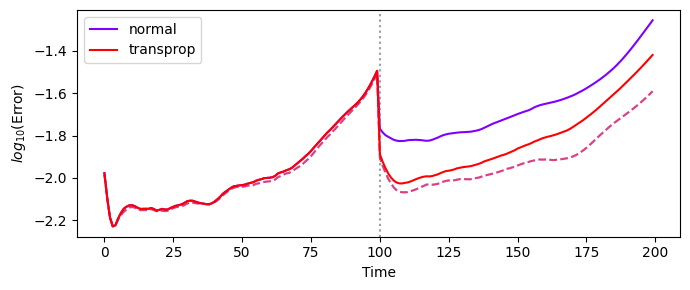

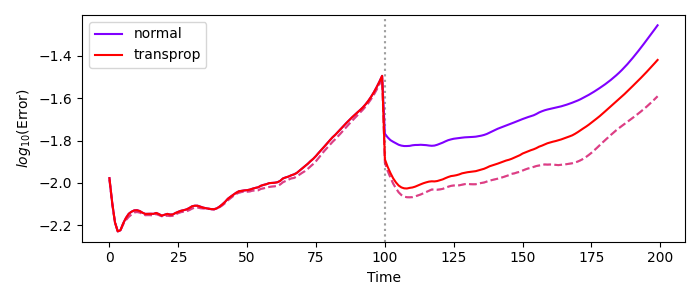

In [ ]:
models.WeldHelper.compare_projops([weldff0, weldtest], ["normal", "transprop"])

In [ ]:
weldff0.save_models()

Models saved at savedmodels/weld/dtrigpoly2_FFAutoencoder_1310307_184506_0_0_0ep_2025-06-17_12-56-15.pickle


Average Relative L2 AE Error over all times: 0.0278


interactive(children=(IntSlider(value=0, description='i', max=249), IntSlider(value=1, description='s'), Outpu…

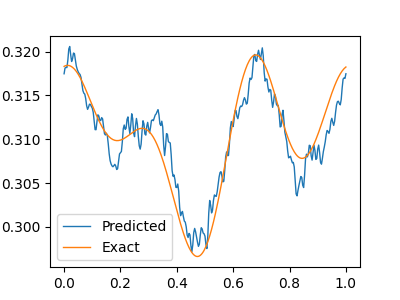

In [ ]:
weldff1 = 

Average Relative L2 AE Error over all times: 0.0283


interactive(children=(IntSlider(value=0, description='i', max=249), IntSlider(value=1, description='s'), Outpu…

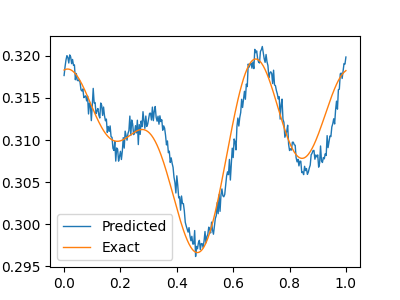

In [ ]:
models.WeldHelper.plot_ae_projection(weldfforig)

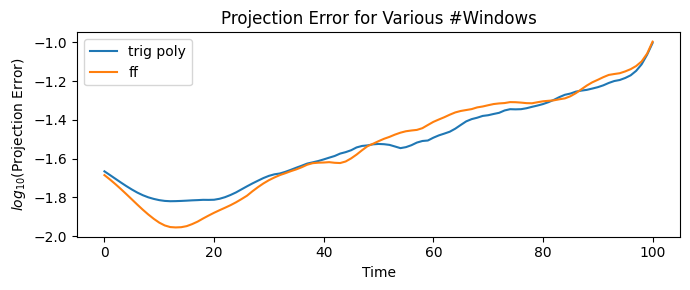

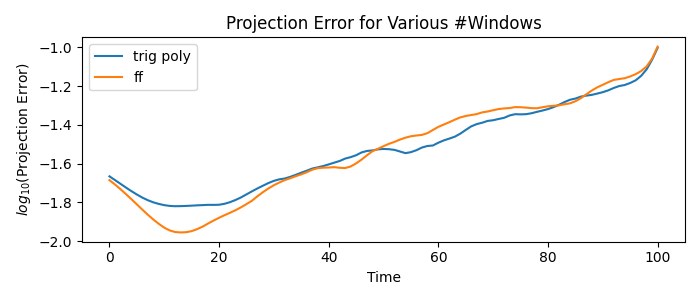

In [ ]:
#models.WeldHelper.plot_coordinate_props(weldff1, difference=False)
models.WeldHelper.compare_projerrs([weldff0, weldfforig], ["trig poly", "ff"])

In [ ]:
wconfig = load_config("../autoencoder/configs/experiments/weldnormal.yaml")
experiment = create_object(wconfig)

weldtest = experiment.create_weld(dset, autonomous=False)

#weldtest.train_aes(

# wpcaconfig = load_config("../autoencoder/configs/experiments/weldpca.yaml")
# wpcaconfig.windows = 3
# wpcaconfig.aeparams.reduced = 10
# pcaexperiment = create_object(wpcaconfig)

AssertionError: 

In [ ]:
#weldtc151 = train_weld_from_yaml("dropletlincomb.yaml", "weldtc.yaml", 6, **dargs)
weldtc51 = train_weld_from_yaml("dropletlincomb.yaml", "weldtc.yaml", 6, **dargs)

Training 1 WeldNet AEs
Number of NN trainable parameters 1185057
Starting training WeldNet AE 1/1 (0->50) at Thu Jun 12 14:53:30 2025...
train torch.Size([200, 51, 301]) test (50, 51, 301)
1: Train Loss 7.550e-03, LR 1.000e-03, Relative AE Error (1, 2, inf): 0.256030, 0.330496, 0.638722
11: Train Loss 2.868e-03, LR 1.000e-03, Relative AE Error (1, 2, inf): 0.144976, 0.189138, 0.454977
21: Train Loss 7.444e-04, LR 1.000e-03, Relative AE Error (1, 2, inf): 0.070433, 0.103445, 0.329307
31: Train Loss 5.175e-04, LR 1.000e-03, Relative AE Error (1, 2, inf): 0.063453, 0.088326, 0.272947
41: Train Loss 3.737e-04, LR 1.000e-03, Relative AE Error (1, 2, inf): 0.054036, 0.075170, 0.225908
51: Train Loss 2.983e-04, LR 1.000e-03, Relative AE Error (1, 2, inf): 0.050855, 0.069174, 0.200678
61: Train Loss 2.473e-04, LR 1.000e-03, Relative AE Error (1, 2, inf): 0.044672, 0.061048, 0.175341
71: Train Loss 2.218e-04, LR 1.000e-03, Relative AE Error (1, 2, inf): 0.043854, 0.058838, 0.160628
81: Train Lo

/Users/bdahal6/Desktop/aenet/.venv/lib/python3.10/site-packages/torch/utils/_device.py:104: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.detach().clone() or sourceTensor.detach().clone().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return func(*args, **kwargs)


11: Train Loss 5.526e-06, LR 1.000e-04, Relative Propagator Error (1, 2, inf): 0.292994, 0.290396, 0.292929
21: Train Loss 2.838e-06, LR 1.000e-04, Relative Propagator Error (1, 2, inf): 0.193957, 0.196025, 0.196993
31: Train Loss 1.997e-06, LR 1.000e-04, Relative Propagator Error (1, 2, inf): 0.146847, 0.145882, 0.145106
41: Train Loss 1.504e-06, LR 1.000e-04, Relative Propagator Error (1, 2, inf): 0.118760, 0.117063, 0.118437
51: Train Loss 1.173e-06, LR 1.000e-04, Relative Propagator Error (1, 2, inf): 0.101466, 0.100330, 0.102131
61: Train Loss 9.632e-07, LR 1.000e-04, Relative Propagator Error (1, 2, inf): 0.089657, 0.088692, 0.090311
71: Train Loss 8.243e-07, LR 1.000e-04, Relative Propagator Error (1, 2, inf): 0.084520, 0.083204, 0.083535
81: Train Loss 7.237e-07, LR 1.000e-04, Relative Propagator Error (1, 2, inf): 0.080999, 0.079501, 0.078813
91: Train Loss 6.533e-07, LR 1.000e-04, Relative Propagator Error (1, 2, inf): 0.078754, 0.076939, 0.075882
101: Train Loss 6.046e-07, L

In [ ]:
models.WeldHelper.pro (weldff)

AttributeError: type object 'WeldHelper' has no attribute 'plot_coordinate_props'

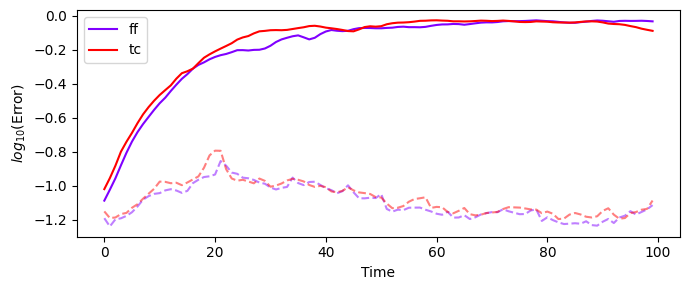

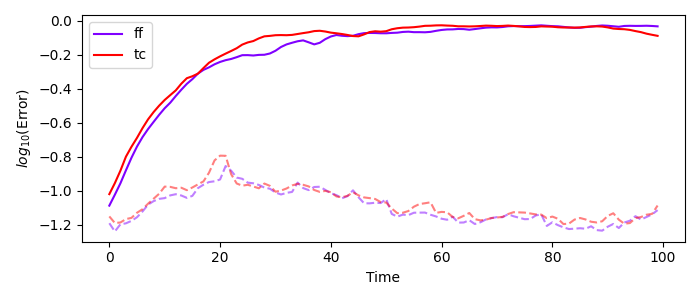

In [ ]:
models.WeldHelper.compare_projops([weldff, weldtc], ["ff", "tc"])

/Users/bdahal6/Desktop/aenet/.venv/lib/python3.10/site-packages/torch/utils/_device.py:104: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.detach().clone() or sourceTensor.detach().clone().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return func(*args, **kwargs)


(<Figure size 700x300 with 1 Axes>,
 <Axes: title={'center': 'o predicted, + exact'}>)

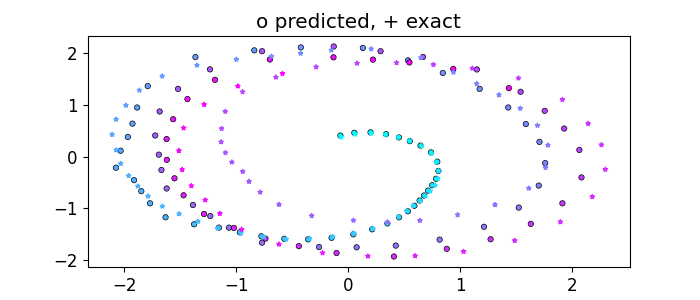

In [ ]:
models.WeldHelper.plot_latent_trajectory(weldff, [1])

/Users/bdahal6/Desktop/aenet/.venv/lib/python3.10/site-packages/torch/utils/_device.py:104: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.detach().clone() or sourceTensor.detach().clone().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return func(*args, **kwargs)


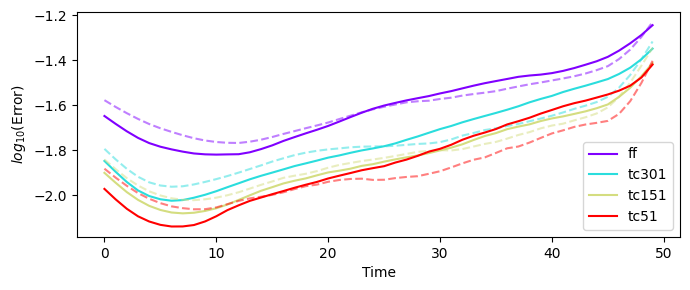

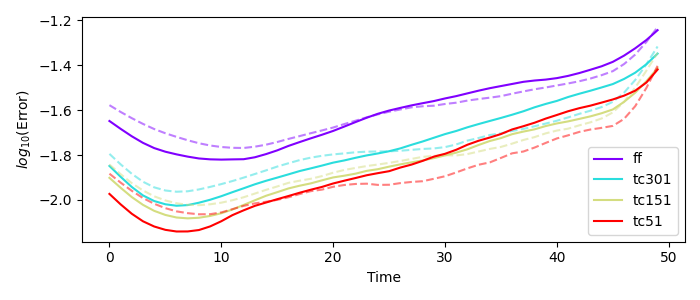

In [ ]:
models.WeldHelper.compare_projops([weldff, weldtc, weldtc151, weldtc51], ["ff", "tc301", "tc151", "tc51"])

0 50


/Users/bdahal6/Desktop/aenet/.venv/lib/python3.10/site-packages/torch/utils/_device.py:104: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.detach().clone() or sourceTensor.detach().clone().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return func(*args, **kwargs)


Average Relative L2 Error over all times: 0.0140


interactive(children=(IntSlider(value=0, description='i', max=249), IntSlider(value=1, description='s', max=50…

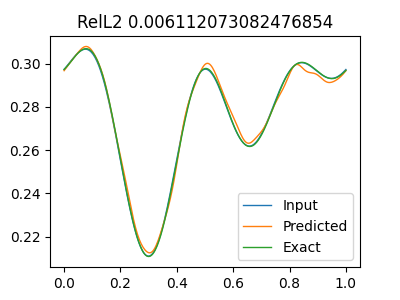

In [ ]:
models.WeldHelper.plot_op_predicts(weldtc31)

0 50


/Users/bdahal6/Desktop/aenet/.venv/lib/python3.10/site-packages/torch/utils/_device.py:104: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.detach().clone() or sourceTensor.detach().clone().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return func(*args, **kwargs)


Average Relative L2 Error over all times: 0.0140


interactive(children=(IntSlider(value=0, description='i', max=249), IntSlider(value=1, description='s', max=50…

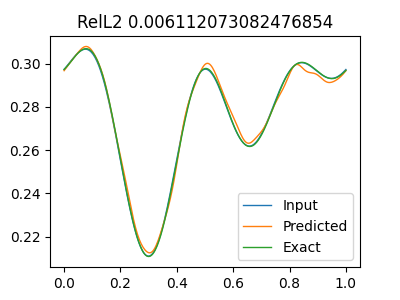

In [ ]:
models.WeldHelper.plot_op_predicts(weldtc31)

In [ ]:
import torch
import torch.nn as nn
import numpy as np

wconfig = load_config("../autoencoder/configs/experiments/weldgi.yaml")
experiment = create_object(wconfig)

#experiment.create_weld(dset, windows=W, k=k, td=None, seed=0, device=device)
 


AttributeError: 'WeldNet' object has no attribute 'get'

In [ ]:
weldff = train_weld_from_yaml("dropletlincomb.yaml", "weldnormal.yaml", 10, **dargs)

Training 1 WeldNet AEs
Number of NN trainable parameters 1314311
Starting training WeldNet AE 1/1 (0->50) at Tue Jun 10 11:26:15 2025...
train torch.Size([200, 51, 301]) test (50, 51, 301)
1: Train Loss 7.058e-03, LR 1.000e-03, Relative AE Error (1, 2, inf): 0.217276, 0.291844, 0.708409
11: Train Loss 3.549e-03, LR 1.000e-03, Relative AE Error (1, 2, inf): 0.162993, 0.210873, 0.494236
21: Train Loss 2.568e-03, LR 1.000e-03, Relative AE Error (1, 2, inf): 0.128832, 0.174509, 0.442031
31: Train Loss 2.316e-03, LR 1.000e-03, Relative AE Error (1, 2, inf): 0.109215, 0.149204, 0.419699
41: Train Loss 2.324e-03, LR 1.000e-03, Relative AE Error (1, 2, inf): 0.104474, 0.142298, 0.381890
51: Train Loss 9.241e-04, LR 1.000e-03, Relative AE Error (1, 2, inf): 0.062566, 0.092784, 0.292345
61: Train Loss 7.147e-04, LR 1.000e-03, Relative AE Error (1, 2, inf): 0.057817, 0.082072, 0.257733
71: Train Loss 5.287e-04, LR 1.000e-03, Relative AE Error (1, 2, inf): 0.050350, 0.071322, 0.216544
81: Train Lo

/Users/bdahal6/Desktop/aenet/.venv/lib/python3.10/site-packages/torch/utils/_device.py:104: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.detach().clone() or sourceTensor.detach().clone().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return func(*args, **kwargs)


11: Train Loss 7.785e-06, LR 1.000e-04, Relative Propagator Error (1, 2, inf): 0.304945, 0.318349, 0.341456
21: Train Loss 3.391e-06, LR 1.000e-04, Relative Propagator Error (1, 2, inf): 0.176780, 0.181752, 0.199210
31: Train Loss 2.312e-06, LR 1.000e-04, Relative Propagator Error (1, 2, inf): 0.135609, 0.144312, 0.172230
41: Train Loss 1.788e-06, LR 1.000e-04, Relative Propagator Error (1, 2, inf): 0.118029, 0.125815, 0.151569
51: Train Loss 1.478e-06, LR 1.000e-04, Relative Propagator Error (1, 2, inf): 0.101827, 0.109829, 0.131687
61: Train Loss 1.280e-06, LR 1.000e-04, Relative Propagator Error (1, 2, inf): 0.091683, 0.099015, 0.119686
71: Train Loss 1.139e-06, LR 1.000e-04, Relative Propagator Error (1, 2, inf): 0.084030, 0.090564, 0.109735
81: Train Loss 1.022e-06, LR 1.000e-04, Relative Propagator Error (1, 2, inf): 0.077589, 0.082672, 0.098733
91: Train Loss 9.248e-07, LR 1.000e-04, Relative Propagator Error (1, 2, inf): 0.072065, 0.075984, 0.088950
101: Train Loss 8.559e-07, L

0 50


/Users/bdahal6/Desktop/aenet/.venv/lib/python3.10/site-packages/torch/utils/_device.py:104: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.detach().clone() or sourceTensor.detach().clone().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return func(*args, **kwargs)


Average Relative L2 Error over all times: 0.0163


interactive(children=(IntSlider(value=0, description='i', max=249), IntSlider(value=1, description='s', max=50…

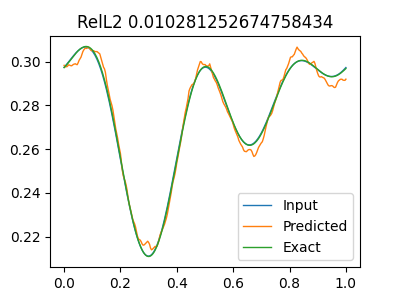

In [ ]:
models.WeldHelper.plot_op_predicts(weldgi)

In [ ]:
weldout3windowtest = copy.deepcopy(weldout3window)

weldout3windowtest.transcoders = []

In [ ]:
models.WeldHelper.compare_projops([weldout1, weldout1kr])

In [ ]:
weldout1 = train_weld_from_yaml("dropletexp.yaml", "weldnormal.yaml", 6)

In [ ]:
models.WeldHelper.plot_op_predicts(weldout1)

In [ ]:
models.WeldHelper.plot_projops(weldout1)

In [ ]:
models.TimeInputHelper.compare_operrs([weldff, weldout1])

In [ ]:
models.TimeInputHelper.plot_op_predicts(weldff)

In [ ]:
weldout7 = train_weld_from_yaml("dropletlincomb.yaml", "weldpca.yaml", 40)
weldout8 = train_weld_from_yaml("dropletexp.yaml", "weldpca.yaml", 40)

In [ ]:
weldout9 = train_weld_from_yaml("dropletlincomb.yaml", "weldpca.yaml", 20)
weldout10 = train_weld_from_yaml("dropletexp.yaml", "weldpca.yaml", 20)

In [ ]:
weldout3 = train_weld_from_yaml("dropletlincomb.yaml", "weldnormal.yaml", 6)
weldout4 = train_weld_from_yaml("dropletexp.yaml", "weldnormal.yaml", 6)

weldout5 = train_weld_from_yaml("dropletlincomb.yaml", "weldpca.yaml", 6)
weldout6 = train_weld_from_yaml("dropletexp.yaml", "weldpca.yaml", 6)

In [ ]:
models.WeldHelper.plot_encoding_window(weldout1, threedim=True, p=1)

In [ ]:
# droplet exp
models.WeldHelper.compare_projops([weldout2, weldout4, weldout6, weldout8], ["ae3", "ae6", "pca6", "pca20"])

In [ ]:
# droplet lincomb
models.WeldHelper.compare_projops([weldout1, weldout3, weldout5, weldout9], ["ae3", "ae6", "pca6", "pca20"])

In [ ]:
import skdim.id
import numpy as np

for dname in ["droplettrigpoly1", "droplettrigpoly2"]:
  print(dname)
  dconfig = load_config(f"../autoencoder/configs/data/{dname}.yaml")
  dconfig.datasize.spacedim = 1
  dset = create_object(dconfig)

  n = dset.data.shape[0]
  T = dset.data.shape[1]
  data0 = dset.data[:, 0].reshape([n, -1])
  dataF = dset.data[:, -1].reshape([n, -1])

  alldata = dset.data.reshape([n*T, -1])
  np.random.shuffle(alldata)
  alldata = alldata[:n]

  estimator = skdim.id.MLE(integral_approximation='guaranteed.convergence')
  print("initial", estimator.fit(data0).dimension_)
  print("final", estimator.fit(dataF).dimension_)
  print("all", estimator.fit(alldata).dimension_)

droplettrigpoly1
initial 1.8516107921901233
final 2.2936826104735664
all 4.3349109937022074
droplettrigpoly2
initial 1.9302106279172349
final 2.047024770198656
all 2.494101397125745


In [ ]:
dset.plot_data()

## dropletexp

Droplet dynamics with initial conditions (where $L$ is the length of the domain):

$u_{[a, b]}(x) = 0.1 + a \cdot e^{-5(x - 0.3L)^2} + b \cdot e^{-5(x - 0.7L)^2}$

and we sample $a, b \sim \text{Unif}([0.1, 0.6])$.

## dropletlincomb

Droplet dynamics with initial conditions:

$u_{[a, b]}(x) = 0.1 + a \cdot \text{base}_1(x) + b \cdot \text{base}_2(x) $

where $ \text{base}_1 $ and $ \text{base}_2$ are degree 4 trigonometric polynomials with coefficients in $[-0.02, 0.02]$.

The data is generated by sampling $a, b \sim \text{Unif}([-1, 1])$.

In [ ]:
import torch
import torch.nn as nn
import torch.fft
import torch.nn.functional as F


class SpectralConv1d(nn.Module):
    """
    1D Fourier‐domain convolution.
    """

    def __init__(self, in_channels: int, out_channels: int, modes: int):
        super().__init__()
        self.in_channels = in_channels
        self.out_channels = out_channels
        self.modes = modes

        # Learnable complex weights (real + imag) for each (in_ch, out_ch, mode)
        self.scale = 1 / (in_channels * out_channels)
        self.weights_real = nn.Parameter(
            self.scale * torch.randn(in_channels, out_channels, self.modes)
        )
        self.weights_imag = nn.Parameter(
            self.scale * torch.randn(in_channels, out_channels, self.modes)
        )

    def compl_mul1d(self, input_ft: torch.Tensor, weights: torch.Tensor) -> torch.Tensor:
        # Complex multiplication in Fourier space: (batch, in_ch, modes) × (in_ch, out_ch, modes)
        return torch.einsum("bik, iok -> bok", input_ft, weights)

    def forward(self, x: torch.Tensor) -> torch.Tensor:
        # x: (batch, in_ch, N)
        batchsize, in_ch, N = x.shape
        x_ft = torch.fft.rfft(x, dim=-1)  # (batch, in_ch, N//2 + 1), dtype=cfloat

        out_ft = torch.zeros(
            (batchsize, self.out_channels, N // 2 + 1),
            dtype=torch.cfloat,
            device=x.device,
        )
        weight_complex = torch.complex(self.weights_real, self.weights_imag)  # (in_ch, out_ch, modes)
        out_ft[:, :, : self.modes] = self.compl_mul1d(x_ft[:, :, : self.modes], weight_complex)

        x_out = torch.fft.irfft(out_ft, n=N, dim=-1)  # (batch, out_ch, N)
        return x_out


class FNO1d(nn.Module):
    """
    1D Fourier Neural Operator with time as an extra input dimension.
    Expects:
      - x0: (batch, N) initial profile u(0, ·)
      - ts: 1D tensor or list of T time-values
    Returns:
      - out: (batch, T, N, 1)
    """

    def __init__(self, modes: int, width: int, depth: int = 4):
        super().__init__()
        self.modes = modes
        self.width = width
        self.depth = depth

        # Lift from 3 features per point [u0(x_i), x_i, t] → width
        self.fc0 = nn.Linear(3, self.width)

        # Stack of (SpectralConv + pointwise Conv1d)
        self.spectral_layers = nn.ModuleList()
        self.pointwise_layers = nn.ModuleList()
        for _ in range(self.depth):
            self.spectral_layers.append(SpectralConv1d(self.width, self.width, self.modes))
            self.pointwise_layers.append(nn.Conv1d(self.width, self.width, kernel_size=1))

        # Project back to scalar at each point
        self.fc1 = nn.Linear(self.width, 128)
        self.fc2 = nn.Linear(128, 1)

    def forward(self, x0: torch.Tensor, ts) -> torch.Tensor:
        # Ensure x0 is (batch, N)
        if x0.ndim == 3 and x0.shape[-1] == 1:
            x0 = x0.squeeze(-1)

        batch, N = x0.shape
        device = x0.device

        # ts → (T,)
        if not torch.is_tensor(ts):
            ts = torch.tensor(ts, device=device, dtype=torch.float32)
        else:
            ts = ts.to(device).float()
        T = ts.shape[0]

        # Spatial grid → (batch, N, 1)
        grid = torch.linspace(0, 1, N, device=device).view(1, N, 1).repeat(batch, 1, 1)

        # Build input channels:
        # u0_channel: (batch, 1, N, 1) → (batch, T, N, 1)
        u0_ch = x0.view(batch, 1, N, 1).repeat(1, T, 1, 1)
        # x_channel: (batch, 1, N, 1) → (batch, T, N, 1)
        x_ch = grid.view(batch, 1, N, 1).repeat(1, T, 1, 1)
        # t_channel: (T,) → (1, T, 1, 1) → (batch, T, N, 1)
        t_ch = ts.view(1, T, 1, 1).repeat(batch, 1, N, 1)

        # Concatenate → (batch, T, N, 3)
        inp = torch.cat((u0_ch, x_ch, t_ch), dim=-1)

        # Merge batch & time → (batch*T, N, 3)
        inp = inp.view(batch * T, N, 3)

        # Lift → (batch*T, N, width)
        x = self.fc0(inp)
        x = F.gelu(x)

        # Prepare for FFT blocks → (batch*T, width, N)
        x = x.permute(0, 2, 1).contiguous()

        # Fourier & pointwise blocks
        for spec, pw in zip(self.spectral_layers, self.pointwise_layers):
            x1 = spec(x)   # (batch*T, width, N)
            x2 = pw(x)     # (batch*T, width, N)
            x = F.gelu(x1 + x2)

        # Back to (batch*T, N, width)
        x = x.permute(0, 2, 1).contiguous()

        # Project to scalar → (batch*T, N, 1)
        x = self.fc1(x)
        x = F.gelu(x)
        x = self.fc2(x)

        # Reshape → (batch, T, N, 1)
        out = x.view(batch, T, N, 1)
        return out


In [ ]:
import copy

wconfig = load_config("../autoencoder/configs/experiments/wweleldpca.yaml")
experiment = create_object(wconfig)

wweld1 = experiment.create_weld(dset, windows=5, k=40, td=None, seed=0, device=device)
wweld2 = experiment.create_weld(dset, windows=5, k=40, td=None, seed=0, device=device)

wweld1.train_aes(1000)
wwweld1.train_propagators(1000)

wweld2 = copy.deepcopy(weld1)

In [ ]:
import copy

wconfig = load_config("../autoencoder/configs/experiments/weldpca.yaml")
experiment = create_object(wconfig)

weld1 = experiment.create_weld(dset, windows=5, k=40, td=None, seed=0, device=device)
weld2 = experiment.create_weld(dset, windows=5, k=40, td=None, seed=0, device=device)

weld1.train_aes(300)
weld1.train_propagators(1000)

weld2 = copy.deepcopy(weld1)

In [ ]:
import models
import time
import glob
import datetime
import copy
import os
import pickle
import torch
import torch.nn as nn
import numpy as np
import matplotlib.pyplot as plt
import ipywidgets as widgets
import seaborn as sns
import deepxde as dde

from itertools import combinations
from sklearn.decomposition import PCA
from sklearn.kernel_ridge import KernelRidge
from torch.utils.tensorboard import SummaryWriter
from torch.utils.data import DataLoader
from torch.optim import lr_scheduler
from copy import deepcopy

def train_transcoders_krr(self, save=True, ridge=1.0, kernel="rbf", gamma=None, encoding_param=-1, printinterval=1):
    encoding_param = models.determine_param(self.dataset, encoding_param)

    testerrors1_all = []
    testerrors2_all = []
    testerrorsinf_all = []

    print(f"Training {self.W} WeldNet Transcoders via Kernel Ridge Regression")
    for w in range(self.W - 1):   
        data_train_raw = torch.tensor(
            self.alltrain[:, self.windowvals[w], :],
            dtype=torch.float,
            device=self.device
        )   # shape: (N_train, raw_dim)

        data_test_raw = torch.tensor(
            self.alltest[:, self.windowvals[w], :],
            dtype=torch.float,
            device=self.device
        )   # shape: (N_test, raw_dim)

        # 4b. Encode them
        encodeddom = self.encode_window(w, data_train_raw[:, 0, :])
        encodedran = self.encode_window(w+1, data_train_raw[:, -1, :]).detach().cpu().numpy() # (N_train, latent_dim)

        encodedtestdom = self.encode_window(w, data_test_raw[:, 0, :])   # (N_test, latent_dim)
        encodedtestran = self.encode_window(w+1, data_test_raw[:, -1, :]).detach().cpu().numpy()  # (N_test, latent_dim)

        # 4c. Fit a KernelRidge model for this window

        t0 = self.windowvals[w][0]
        t1 = self.windowvals[w][-1]
        encodedinputs = self.propagate(encodeddom, t0, t1-t0, arrencoded=True, fixedw=w)[-1].cpu().detach().numpy()
        kr_model = KernelRidge(alpha=ridge, kernel=kernel, gamma=gamma)
        
        if self.residualprop:
          kr_model.fit(encodedinputs, encodedran - encodedinputs)
        else:
          kr_model.fit(encodedinputs, encodedran)  

        # 4d. Store model
        if len(self.transcoders) > w:
            self.transcoders[w] = kr_model
        else:
            self.transcoders.append(kr_model)

        # 4e. Compute test-set predictions and relative errors
        encodedinputstest = self.propagate(encodedtestdom, t0, t1-t0, arrencoded=True, fixedw=w)[-1].cpu().detach().numpy()
        pred_test = kr_model.predict(encodedinputstest)  # (N_test, latent_dim)

        if self.residualprop:
          pred_test = encodedinputstest + pred_test

        # Compute relative L1, L2, L∞ for each test sample
        rel1 = np.mean(
          np.linalg.norm(encodedtestran - pred_test, axis=1, ord=1)
          / np.linalg.norm(encodedtestran, axis=1, ord=1)
        )
        rel2 = np.mean(
          np.linalg.norm(encodedtestran - pred_test, axis=1, ord=2)
          / np.linalg.norm(encodedtestran, axis=1, ord=2)
        )
        relinf = np.mean(
          np.linalg.norm(encodedtestran - pred_test, axis=1, ord=np.inf)
          / np.linalg.norm(encodedtestran, axis=1, ord=np.inf)
        )

        testerrors1_all.append(rel1)
        testerrors2_all.append(rel2)
        testerrorsinf_all.append(relinf)

        print(
            f"Window {w+1}/{self.W-1}: "
            f"Relative Test Error (L1, L2, Linf) = "
            f"{rel1:.3e}, {rel2:.3e}, {relinf:.3e}"
        )

    if save and False:
      pass

    print("Finished training all timewindow transcoders using KRR")
    return {
      "testerrors1": testerrors1_all,
      "testerrors2": testerrors2_all,
      "testerrorsinf": testerrorsinf_all
    }

In [ ]:
weld1.train_transcoders(1000)

In [ ]:
train_transcoders_krr(weld2, save=False, ridge=1e-4, kernel="rbf")

In [ ]:
import models

models.WeldHelper.plot_op_predicts(weld2)

In [ ]:
import models

models.WeldHelper.plot_projops(weld2)

In [ ]:
models.WeldHelper.plot_prop_scatter(weld2)

In [ ]:
fconfig = load_config("../autoencoder/configs/experiments/ffnetbig.yaml")
fexperiment = create_object(fconfig)

mlp = fexperiment.create_timeinput(dset)
mlp.train_model(1000, lr=1e-3)

In [ ]:
#models.TimeInputHelper.plot_op_predicts(mlp)
models.WeldHelper.plot_op_predicts(weld1)

In [ ]:
import models

models.WeldHelper.plot_op_predicts(weld1)

In [ ]:
import time
import glob
import datetime
import copy
import os
import pickle
import torch
import torch.nn as nn
import numpy as np
import matplotlib.pyplot as plt
import ipywidgets as widgets
import seaborn as sns
import deepxde as dde

from itertools import combinations
from sklearn.decomposition import PCA
from torch.utils.tensorboard import SummaryWriter
from torch.utils.data import DataLoader
from torch.optim import lr_scheduler
from copy import deepcopy

import utils
from omegaconf import DictConfig, OmegaConf


def get_proj_errors(model, testarr, ords=(2,)):
  if isinstance(testarr, np.ndarray):
    testarr = torch.tensor(testarr, dtype=torch.float32)
    
  proj = model(testarr)
  
  if len(testarr.shape) > 3:
    assert(len(testarr.shape) == 4)
    testarr = testarr.reshape(list(testarr.shape[:-2]) + [-1])
    proj = proj.reshape(list(proj.shape[:-2]) + [-1])

  n = testarr.shape[0]
  testarr = testarr.cpu().detach().numpy().reshape([n, -1])
  proj = proj.cpu().detach().numpy().reshape([n, -1])

  testerrs = []
  for o in ords:
    testerro = np.mean(np.linalg.norm(testarr - proj, axis=1, ord=o) / np.linalg.norm(testarr, axis=1, ord=o))
    testerrs.append(testerro)

  return tuple(testerrs)


def finetune_ae_with_prop(self, epochs, save=True, lr=1e-4, batch=32, ridge=0, printinterval=10, loss=None, best=True, plottb=False):
    def finetune_epoch(ae, prop, dataloader, writer=None, optimizer=None, scheduler=None, ep=0, printinterval=10, loss=None, testarr=None):
      def closure(batch):
        optimizer.zero_grad()

        assert(self.straightness + self.kinetic == 0)
        
        x = batch[:, :-1, :].to(self.device)  # [B, T-1, D]
        y = batch[:, 1:, :].to(self.device)   # [B, T-1, D]

        z = ae.encode(x)                     # Encode
        with torch.no_grad():
          if self.residualprop:
            z_next = prop(z) + z
          else:
            z_next = prop(z)
            
        y_hat = ae.decode(z_next)

        res = loss(y_hat, y)
        res.backward()
        opt.step()

        losses.append(float(res.detach().cpu()))
        scheduler.step(np.mean(losses))
 
        if writer is not None and self.aestep % 5:
          writer.add_scalar("main/loss", float(res.cpu().detach()), global_step=self.aestep)

        return res
      
      losses = []
      testerrors1 = []
      testerrors2 = []
      testerrorsinf = []

      device = self.device

      for batch in dataloader:
        self.aestep += 1
        error = optimizer.step(lambda: closure(batch))
        losses.append(float(error.cpu().detach()))

      if scheduler is not None:
        scheduler.step(np.mean(losses))

      # print test
      if printinterval > 0 and (ep % printinterval == 0):
        testerr1, testerr2, testerrinf = get_proj_errors(ae, testarr, ords=(1, 2, np.inf))
        if scheduler is not None:
          print(f"{ep+1}: Train Loss {error:.3e}, LR {scheduler.get_last_lr()[-1]:.3e}, Relative AE Error (1, 2, inf): {testerr1:3f}, {testerr2:3f}, {testerrinf:3f}")
        else:
          print(f"{ep+1}: Train Loss {error:.3e}, Relative AE Error (1, 2, inf): {testerr1:3f}, {testerr2:3f}, {testerrinf:3f}")

        if writer is not None:
            writer.add_scalar("misc/relativeL1proj", testerr1, global_step=ep)
            writer.add_scalar("main/relativeL2proj", testerr2, global_step=ep)
            writer.add_scalar("misc/relativeLInfproj", testerrinf, global_step=ep)

      return losses, testerrors1, testerrors2, testerrorsinf

    if loss is None:
      loss = nn.MSELoss()
    else:
      loss = loss()

    print(f"Fine-tuning {self.W} AEs using fixed propagators")

    losses_all, testerrors1_all, testerrors2_all, testerrorsinf_all = [], [], [], []
    for w in range(self.W):
      self.aestep = 0
      ae = self.aes[w]
      prop = self.props[w]

      train = torch.tensor(self.alltrain[:, self.windowvals[w], :], dtype=torch.float32).to(self.device)
      test = torch.tensor(self.alltest[:, self.windowvals[w], :], dtype=torch.float32).to(self.device)

      dataloader = DataLoader(train, batch_size=batch)
      opt = torch.optim.AdamW(ae.decoder.parameters(), lr=lr, weight_decay=ridge)
      scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(opt, patience=10)

      print(f"Fine-tuning AE {w+1}/{self.W}...")

      writer = None
      losses, testerrors1, testerrors2, testerrorsinf = [], [], [], []
      bestdict = { "loss": float(np.inf), "ep": 0 }

      for ep in range(epochs):
        lossesN, testerrors1N, testerrors2N, testerrorsinfN = finetune_epoch(ae, prop, dataloader, scheduler=scheduler, optimizer=opt, writer=writer, ep=ep, printinterval=printinterval, loss=loss, testarr=test)
        losses += lossesN; testerrors1 += testerrors1N; testerrors2 += testerrors2N; testerrorsinf += testerrorsinfN

        if best and ep > epochs // 2:
          avgloss = np.mean(lossesN)
          if avgloss < bestdict["loss"]:
            bestdict["model"] = ae.state_dict()
            bestdict["opt"] = opt.state_dict()
            bestdict["loss"] = avgloss
            bestdict["ep"] = ep
          elif verbose:
            print(f"Loss not improved at epoch {ep} (Ratio: {avgloss/bestdict['loss']:.2f}) from {bestdict['ep']} (Loss: {bestdict['loss']:.2e})")

        if ep % 5 == 0 and plottb:
          WeldHelper.plot_encoding_window(self, w, encoding_param, step=self.aestep, writer=writer, tensorboard=True)
      
      print(f"Finished fine-tuning AE {w+1}/{self.W}")
      losses_all.append(losses)
      testerrors1_all.append(testerrors1)
      testerrors2_all.append(testerrors2)
      testerrorsinf_all.append(testerrorsinf)

      if best:
        ae.load_state_dict(bestdict["model"])
        opt.load_state_dict(bestdict["opt"])

    self.aedata.append((epochs))

    if save and False:
      pass

    print("Finished finetuning all timewindows")
    return { "losses": losses, "testerrors1": testerrors1, "testerrors2": testerrors2, "testerrorsinf": testerrorsinf}

In [ ]:
finetune_ae_with_prop(weld2, 300, save=False, lr=1e-3, printinterval=10)

In [ ]:
import models

models.WeldHelper.compare_projops([weld1, weld2], ["normal", "finetuned"])

In [ ]:
weld2 = experiment.create_weld(dset, windows=1, k=4, td=None, seed=0, device=device, accumulateprop=True, decodedprop=False)

weld2.train_aes(300, lr=1e-3, printinterval=10, save=False)
weld2.train_propagators(300, lr=1e-4, printinterval=10, save=False)

In [ ]:
import models
import numpy as np
np.mean(models.WeldHelper.get_projerr(weld1))

In [ ]:
import models
np.mean(models.TimeInputHelper.get_operrs(mlp))

In [ ]:
import torch
import torch.nn as nn
from torch.utils.data import DataLoader, TensorDataset


# ---------------------- SpectralConv1d ----------------------
class SpectralConv1d(nn.Module):
    def __init__(self, in_channels, out_channels, modes):
        super().__init__()
        self.in_channels = in_channels
        self.out_channels = out_channels
        self.modes = modes
        self.scale = 1 / (in_channels * out_channels)
        self.weights1 = nn.Parameter(
            self.scale * torch.randn(in_channels, out_channels, modes, dtype=torch.cfloat)
        )

    def compl_mul1d(self, input, weights):
        return torch.einsum("bix, iox ->box", input, weights)

    def forward(self, x):
        B, C, L = x.shape
        x_ft = torch.fft.rfft(x, dim=-1)
        out_ft = torch.zeros(B, self.out_channels, x_ft.shape[-1], dtype=torch.cfloat, device=x.device)
        out_ft[:, :, :self.modes] = self.compl_mul1d(x_ft[:, :, :self.modes], self.weights1)
        x = torch.fft.irfft(out_ft, n=L, dim=-1)
        return x


# ---------------------- FNO1d with time input ----------------------
class FNO1d(nn.Module):
    def __init__(self, modes, width):
        super().__init__()
        self.modes = modes
        self.width = width

        self.fc0 = nn.Linear(2, width)  # input: (x₀, t)

        self.conv_layers = nn.ModuleList([
            SpectralConv1d(width, width, modes) for _ in range(4)
        ])
        self.w_layers = nn.ModuleList([
            nn.Conv1d(width, width, 1) for _ in range(4)
        ])

        self.fc1 = nn.Linear(width, 128)
        self.fc2 = nn.Linear(128, 1)  # output: x(t)

    def forward(self, x0, t):
        # x0: (B, L, 1), t: (B, 1)
        B, L, _ = x0.shape
        t_expanded = t.unsqueeze(-1).expand(-1, L, 1)  # (B, L, 1)
        x = torch.cat([x0, t_expanded], dim=-1)        # (B, L, 2)

        x = self.fc0(x)                   # (B, L, width)
        x = x.permute(0, 2, 1)            # (B, width, L)

        for conv, w in zip(self.conv_layers[:-1], self.w_layers[:-1]):
            x = torch.relu(conv(x) + w(x))
        x = self.conv_layers[-1](x) + self.w_layers[-1](x)

        x = x.permute(0, 2, 1)            # (B, L, width)
        x = torch.relu(self.fc1(x))
        x = self.fc2(x)                   # (B, L, 1)
        return x.permute(0, 2, 1)         # (B, 1, L)


# ---------------------- Training Loop ----------------------
def train_fno(model, dataset, batch_size=32, epochs=100, lr=0.001, device="cpu"):
    model.to(device)
    loader = DataLoader(dataset, batch_size=batch_size, shuffle=False)
    optimizer = torch.optim.Adam(model.parameters(), lr=lr)
    loss_fn = nn.MSELoss()

    for ep in range(epochs):
        model.train()
        total_loss = 0.0
        for x0, t, y in loader:
            x0, t, y = x0.to(device), t.to(device), y.to(device)
            optimizer.zero_grad()
            pred = model(x0, t)
            loss = loss_fn(pred, y)
            loss.backward()
            optimizer.step()
            total_loss += loss.item() * x0.size(0)

        avg_loss = total_loss / len(loader.dataset)
        if ep % 10 == 0 or ep == epochs - 1:
            print(f"Epoch {ep}: Loss = {avg_loss:.6f}")


data = torch.tensor(dset.data)
# Assume: dset.data.shape = (N, T+1, L)
x0 = data[:, 0, :]          # (N, L)   -- initial state
ys = data[:, 1:6, :]         # (N, T, L) -- future states
T = ys.shape[1]
N = ys.shape[0]

# Repeat each (x₀, t) pair for all t ∈ [1, ..., T]
x_repeated = x0.unsqueeze(1).repeat(1, T, 1)    # (N, T, L)
t_vals = torch.linspace(1, T, T) / T            # normalized time ∈ [0, 1]
t_repeated = t_vals.unsqueeze(0).repeat(N, 1)   # (N, T)

# Flatten all dims so each example is (x₀, t, u_t)
x_flat = x_repeated.reshape(-1, x0.shape[1], 1)   # (N*T, L, 1)
t_flat = t_repeated.reshape(-1, 1)                # (N*T, 1)
y_flat = ys.reshape(-1, ys.shape[2])              # (N*T, L)
y_flat = y_flat.unsqueeze(1)                      # (N*T, 1, L)

# Build dataset
dataset = TensorDataset(x_flat, t_flat, y_flat)

# Train
model = FNO1d(modes=16, width=64)
train_fno(model, dataset, batch_size=32, epochs=100, device=device)


In [ ]:
import matplotlib.pyplot as plt
from ipywidgets import interact, FloatSlider
import numpy as np
import torch

def plot_dataset_sample_with_slider(model, dataset, x_grid, sample_idx=0, t_range=(0, 2 * np.pi), device="cpu"):
    model.eval()
    
    x0, _, _ = dataset[sample_idx]  # Proper unpacking from TensorDataset
    x0 = x0.unsqueeze(0).to(device)  # (1, L, 1)
    x_grid_np = x_grid.cpu().numpy()

    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 4))

    @interact(t=FloatSlider(min=t_range[0], max=t_range[1], step=0.05, value=t_range[0]))
    def plot_at_t(t):
        ax1.clear()
        ax2.clear()

        t_tensor = torch.tensor([[t]], dtype=torch.float32).to(device)
        with torch.no_grad():
            pred = model(x0, t_tensor).squeeze().cpu().numpy()

        # Only works if ground truth is known to be sin(x) * cos(t)
        true_u = torch.sin(x_grid) * torch.cos(torch.tensor(t))
        true_u = true_u.cpu().numpy()

        ax1.plot(x_grid_np, true_u, 'k--')
        ax1.set_title(f"Ground Truth at t={t:.2f}")
        ax1.set_xlabel("x")
        ax1.set_ylabel("u(x, t)")
        ax1.grid(True)

        ax2.plot(x_grid_np, pred, 'r-')
        ax2.set_title(f"Prediction at t={t:.2f}")
        ax2.set_xlabel("x")
        ax2.set_ylabel("û(x, t)")
        ax2.grid(True)

        fig.suptitle(f"Sample {sample_idx}: FNO Prediction vs Ground Truth", fontsize=14)
        fig.tight_layout()

plot_dataset_sample_with_slider(model, dataset, x_grid, sample_idx=3, device=device)


In [ ]:
import torch
import torch.nn as nn
import torch.fft

import torch
import torch.nn as nn

# ---------------------- SpectralConv1d ----------------------
class SpectralConv1d(nn.Module):
    def __init__(self, in_channels, out_channels, modes):
        super().__init__()
        self.in_channels = in_channels
        self.out_channels = out_channels
        self.modes = modes
        self.scale = 1 / (in_channels * out_channels)
        self.weights1 = nn.Parameter(
            self.scale * torch.randn(in_channels, out_channels, modes, dtype=torch.cfloat)
        )

    def compl_mul1d(self, input, weights):
        # Proper complex multiplication
        return torch.einsum("bix, iox ->box", input, weights)

    def forward(self, x):
        B, C, L = x.shape
        x_ft = torch.fft.rfft(x, dim=-1)
        out_ft = torch.zeros(B, self.out_channels, x_ft.shape[-1], dtype=torch.cfloat, device=x.device)
        out_ft[:, :, :self.modes] = self.compl_mul1d(x_ft[:, :, :self.modes], self.weights1)
        x = torch.fft.irfft(out_ft, n=L, dim=-1)
        return x


# ---------------------- FNO1d Model ----------------------
class FNO1d(nn.Module):
    def __init__(self, modes, width):
        super().__init__()
        self.modes = modes
        self.width = width

        self.fc0 = nn.Linear(1, width)  # Assumes input features = 1

        self.conv_layers = nn.ModuleList([
            SpectralConv1d(width, width, modes) for _ in range(4)
        ])
        self.w_layers = nn.ModuleList([
            nn.Conv1d(width, width, 1) for _ in range(4)
        ])

        self.fc1 = nn.Linear(width, 128)
        self.fc2 = nn.Linear(128, 1)

    def forward(self, x):
        # Input: (B, L, 1)
        assert x.dim() == 3 and x.shape[-1] == 1, "Expected input of shape (B, L, 1)"

        x = self.fc0(x)                   # (B, L, width)
        x = x.permute(0, 2, 1)            # (B, width, L)

        for conv, w in zip(self.conv_layers[:-1], self.w_layers[:-1]):
            x = torch.relu(conv(x) + w(x))

        # Final conv layer without ReLU
        x = self.conv_layers[-1](x) + self.w_layers[-1](x)

        x = x.permute(0, 2, 1)            # (B, L, width)
        x = torch.relu(self.fc1(x))
        x = self.fc2(x)
        return x.permute(0, 2, 1)         # (B, 1, L)


# ---------------------- Training Loop ----------------------
def train_fno(model, data, batch_size=64, epochs=100, lr=0.001, device="cpu", eval_fn=None):
    model.to(device)

    x = data[:, 0, :].unsqueeze(-1)  # (N, L, 1)
    y = data[:, 1, :].unsqueeze(1)   # (N, 1, L)
    dataset = TensorDataset(x, y)
    dataloader = DataLoader(dataset, batch_size=batch_size)

    optimizer = torch.optim.Adam(model.parameters(), lr=lr)
    loss_fn = nn.MSELoss()

    for ep in range(epochs):
        model.train()
        total_loss = 0.0

        for xb, yb in dataloader:
            xb, yb = xb.to(device), yb.to(device)
            optimizer.zero_grad()
            out = model(xb)
            loss = loss_fn(out, yb)
            loss.backward()
            optimizer.step()
            total_loss += loss.item() * xb.size(0)

        avg_loss = total_loss / len(dataloader.dataset)
        if ep % 10 == 0 or ep == epochs - 1:
            print(f"Epoch {ep}: Loss = {avg_loss:.6f}")
            if eval_fn:
                model.eval()
                with torch.no_grad():
                    eval_fn(model)


device = "cpu"
dset_data = torch.tensor(dset.data[:, [0, -1], :], dtype=torch.float32).to(device)

split = int(0.8 * len(dset_data))
train_data = dset_data[:split]
test_data = dset_data[split:]

model = FNO1d(modes=16, width=100).to(device)

# After training on train_data...
train_fno(model, train_data, epochs=300, device=device)

In [ ]:

# Now test on test_data
x_test = test_data[:, 0, :].unsqueeze(-1).to(device)  # (B, L, 1)
y_true = test_data[:, 1, :].unsqueeze(1).to(device)   # (B, 1, L)

model.eval()
with torch.no_grad():
    y_pred = model(x_test)                            # (B, 1, L)

# Compute relative L2 error
rel_error = torch.norm(y_pred - y_true) / torch.norm(y_true)
print(f"Relative L2 error on test set: {rel_error.item():.4f}")


In [ ]:
import models

models.WeldHelper.plot_ae_projection(weld, testonly=True)

In [ ]:
model

In [ ]:
dset.plot_data(mode="params")

In [ ]:
wpcaconfig = load_config("../autoencoder/configs/experiments/weldpca.yaml")
wpcaconfig.windows = 1
pcaexperiment = create_object(wpcaconfig)

In [ ]:
pca = pcaexperiment.create_weld(dset)
pca.load_all(dset.name)

In [ ]:
models.WeldHelper.plot_op_predicts(pca)

In [ ]:
wconfig = load_config("../autoencoder/configs/experiments/ffnetnormal.yaml")
experiment = create_object(wconfig)

wconfig2 = load_config("../autoencoder/configs/experiments/donnormal.yaml")
experiment2 = create_object(wconfig2)

model1 = experiment.create_timeinput(dset)
model1.load_model(dset.name)
model2 = experiment2.create_timeinput(dset)
model2.train_model(500)

In [ ]:
import models

import ipywidgets as widgets

import matplotlib.pyplot as plt
import numpy as np
import torch

fig = experiment.compare_operrs([model1, model2])

#fig.axes[0].set_yscale("log")

In [ ]:
import models

models.WeldAnalyzer.compare_projops([weld, weldpca], labels=["AE", "PCA"])

In [ ]:
models.WeldAnalyzer.get_projerr_windows(weld, testonly=True)

In [ ]:
import utils
import torch

data = weld.tests[0] 
data = utils.collect_times_dataparams(data)
data = torch.tensor(data).to(weld.device).float()
proj = weld.project_window(0, data).cpu().detach().numpy()
data = data.cpu().detach().numpy()

print(data.shape)

In [ ]:
out = models.WeldAnalyzer.plot_projops(weld)

In [ ]:
import models
import matplotlib.pyplot as plt

out = models.WeldAnalyzer.plot_op_predicts(weld2)

In [ ]:
models.WeldAnalyzer.plot_encoding_window(weld)

In [ ]:
out = models.WeldAnalyzer.plot_ae_projection(weld2)

In [ ]:
weld.train_propagators(200)

In [ ]:
weld.train_transcoders(200)

In [ ]:
import models

out = models.WeldAnalyzer.plot_op_predicts(weld)

In [ ]:
# Setup code

import sys
sys.path.insert(0, "..")
basedir = "../.."

import datetime
import skdim
import glob
import time
import torch
import torch.nn as nn
import matplotlib.pyplot as plt
import numpy as np
import pickle
import re
import os
import ipywidgets as widgets

from sklearn.decomposition import PCA
from torch.utils.data import DataLoader
from torchdiffeq import odeint

import models
import utils

from models import WeldAnalyzer

%matplotlib widget
plt.rcParams["figure.figsize"] = (7, 4)
device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')

dset = (f"{basedir}/datasets/burgers2d/burgers2d_widths_BIG.mat", "alldata")

#dset = (f"{basedir}/datasets/transport/hats2_2500_scale.mat", "alldata")
dataset = utils.DynamicData(dset, spacedim=2)

In [ ]:
dataset.downsample_time(2)
dataset.downsample(2)

In [ ]:
dataset.plot_data(mode="params")